# TOC

1. [Introduction](#Introduction)
    1. [Task explanation](#Task-explanation)
    1. [Raw data example](#Raw-data-example)
1. [Preprocessing, cleaning, and feature generation](#Preprocessing,-cleaning,-and-feature-generation)
1. [Code. Run preprocessing](#Code.-Run-preprocessing)
1. [Data Analysis](#Data-Analysis)
    1. [Testing: Overall](#Testing:-Overall)
        1. Testing: Calendar of tests
        1. Testing: Trends by day
        1. Testing: Trends by week and location
    1. [Testing: In-Depth Look](#Testing:-In-Depth-Look)
        1. Testing: When we test?
        1. Testing: Features. Distance & Test length
        1. Testing: Features. Distance by location and vehicle
        1. Testing: Features. Test distance per locations
        1. Testing: Features. Interventions and distance traveled per location
    1. [Testing: Executive Metrics Report](#Testing:-Executive-Metrics-Report)
    1. [Troubleshooting view](#Troubleshooting-view)
        1. Troubleshooting: Calendar of troubleshootings
        1. Troubleshooting: Troubleshootings length by Root Cause
    1. [Troubleshooting: Executive Metrics Report](#Troubleshooting:-Executive-Metrics-Report)
    1. [Experiment Part. Testing and Troubleshooting: Connection](#Experiment-Part.-Testing-and-Troubleshooting:-Connection)


[To table of contents](#TOC)
***

# Introduction

## Task explanation
**We have** `testing` and `troubleshooting` CSV datasets describing CAV field operations data.

> The origin of data is either real operations (_physical world, computer simulations_) or purpose-based mock (to demonstrate an overall data format and test people, so may be artificially distorted). There are more then one anonymized testing locations and every location contain more than one anonymized car testing there. Two datasets connected in `one (test) to many (troubles)` way (however, this part is rather incomplete and 'grey')

**We need** to `provide informational support` (meaningful explanation, notes, visualisations) above this data.
> Audience are Middle, Field and Executive-level management. Engaged actors are operational analysts

**Suggested Format:**
> * 2-5 slides presenting key takeaways to a ground-level management audience
> * 2-3 slides presenting high-level insights to an executive level audience
> * 1+ slides presenting thoughts on future analysis
> * 1-2 slides describing your analysis and methods

## Raw data example
> Testing

| TEST_ID 	| TEST_LOCATION 	| VEHICLE_ID 	| START_TIMESTAMP 	| END_TIMESTAMP       	| DISTANCE_TRAVELED_M 	| INTERVENTIONS 	|
|---------------	|------------	|-----------------	|---------------------	|---------------------	|---------------	|-----	|
| 1217386.0     	| AA         	| V01             	| 2021-07-20 22:34:37 	| 2021-07-20 22:45:16 	| 0.001237      	| 1.0 	|
| 1174333.0     	| BB         	| V02             	| 2021-07-01 13:26:32 	| 2021-07-01 13:54:34 	| 2595.160572   	| 0.0 	|
| 1316749.0     	| CC         	| V03             	| 2021-08-31 14:24:29 	| 2021-08-31 15:47:00 	| 94309.710064  	| 0.0 	|

> Troubleshooting

| TEST_ID 	| TEST_LOCATION 	| VEHICLE_ID 	| START_TIMESTAMP 	| END_TIMESTAMP       	| DISTANCE_TRAVELED_M 	| INTERVENTIONS 	|
|---------------	|------------	|-----------------	|---------------------	|---------------------	|---------------	|-----	|
| 1217386.0     	| AA         	| V01             	| 2021-07-20 22:34:37 	| 2021-07-20 22:45:16 	| 0.001237      	| 1.0 	|
| 1174333.0     	| BB         	| V02             	| 2021-07-01 13:26:32 	| 2021-07-01 13:54:34 	| 2595.160572   	| 0.0 	|
| 1316749.0     	| CC         	| V03             	| 2021-08-31 14:24:29 	| 2021-08-31 15:47:00 	| 94309.710064  	| 0.0 	|

> The 'gray zone' is connection between two

```
Test 1270798, Location CC
Test from 2021-08-11 01:27:36 to 2021-08-11 04:19:57
                
    Trouble one from 2021-08-10 23:50:34 to 2021-08-11 00:42:34
    Trouble two from 2021-07-12 19:31:12 to 2021-07-12 20:47:12
    
Source: pd.merge(test_data, troubleshoot_data, left_on='TEST_ID', right_on='TEST_ID', how='outer')  
    Many test id are unique for one of frames, many troubles are outside of test [start, end] range
```

[To table of contents](#TOC)
***

## Preprocessing, cleaning, and feature generation

**To preprocess data**, we do
* Map the data types (ids and number of interventions are ints, distances are float, time is time up to seconds precision)
* Write reproducible pipeline from raw to interim to analytical-ready data file

**To generate features**, we do
* Extract features from date-time timestamps (date, year, month, week number, day of week number, hour, time)
* Calculate test length, troubleshooting length (diff between end and start)
* Converse distance traveled in meters to miles (meters to miles)
* Calculate vehicle speed per test (traveled distance devided by test time)
* Calculate interventions per mile for test (number of interventions devided by traveled distance)
* Calculate trouble per test (sum of troubles)
    * We might add binding (range, bound)-based features, like categorical 'small distance' or 'fast-fixing troubleshooting' and binary 'more than one intervention', 'more then one trouble' to reduce granularity and number of dimensions
    * We might use 'target encoding'-like approach and add highly-derivative features, like 'interventions per location for last 7 days', 'mean number of interventions per this vehicle' or add derivative features, like 'interventions per distance or time', both to get deeper picture, plus to account order of troubles per day, per location or per test to estimate workload or possible work priorities of staff
    * We might deploy additional data - weather, road conditions, difficulty of tests case (test scenario and operational domain), usuality of trouble of interventions
    * We might to acount connections between testing and troubleshooting, like get 'raw operating length', 'share of troubleshooting time' 

**To clean data**, we do
* Remove records with improper locations codes (hold format: `2 letters uppercase`), vehicle codes (hold format: `uppercase letter V and 2 digits`)
* Remove observations with negative number of interventions
* Remove records with extreme values of traveled distance (> 1 Billion meters, hold distance between `[0.0, 1e8]`)
* Remove records with testing or troubleshooting timestamps earlier then 2020 and later then 2021, hold `2020 and 2021 only`
* Remove records with extreme length of test or troubleshooting (> 1 year, hold length between `[0 sec, 365 days]`)
* Remove records with extreme values of vehicle speed (> 0.5 Mach or ~150 m/s, ~300 mph)
    * In practice, this conditions should be a part of continuous data monitoring involving multiple parts of a company

[To table of contents](#TOC)
***

# Code. Run preprocessing

Import packages 
* built-in
* third-party
* custom scripts

In [1]:
import sys; sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.facecolor'] = 'white'
import matplotlib.dates as mdates
%matplotlib inline

import seaborn as sns
import july
import ptitprince as pt
#import pandas_profiling

import warnings; warnings.filterwarnings('ignore')

import src.feature_generation as feature_generation
import src.analytical_processing as analytical_processing
import src.visualisations as visuals_prepared
import importlib
importlib.reload(feature_generation); importlib.reload(visuals_prepared);
importlib.reload(analytical_processing);

In [2]:
test_data = pd.read_excel('../data/raw/Operations Analytics - Case Study.xlsx', sheet_name='TEST_DATA')
troubleshoot_data = pd.read_excel('../data/raw/Operations Analytics - Case Study.xlsx', sheet_name='TS_DATA')

In [3]:
display(test_data.head(3))
display(troubleshoot_data.head(3))

,TEST_ID,TEST_LOCATION,VEHICLE_ID,START_TIMESTAMP,END_TIMESTAMP,DISTANCE_TRAVELED_M,INTERVENTIONS
0,1217386.0,AA,V01,2021-07-20 22:34:37,2021-07-20 22:45:16,0.001237,1.0
1,1174333.0,BB,V02,2021-07-01 13:26:32,2021-07-01 13:54:34,2595.160572,0.0
2,1316749.0,CC,V03,2021-08-31 14:24:29,2021-08-31 15:47:00,94309.710064,0.0


,TEST_ID,TROUBLESHOOTING_ID,TROUBLESHOOTING_START,TROUBLESHOOTING_END,ROOT CAUSE
0,1085464.0,1090474.0,2021-06-01 13:26:33,2021-06-01 13:45:33,HARDWARE
1,1055111.0,1090776.0,2021-06-01 15:01:07,2021-06-01 15:25:07,SOFTWARE
2,1055111.0,1090821.0,2021-06-01 14:38:19,2021-06-01 14:38:19,OPERATIONS


Match and set proper types for fields

In [4]:
# Data types
## type matching
test_data = test_data.astype({'TEST_ID': int, 'DISTANCE_TRAVELED_M': float, 'INTERVENTIONS' : int})
troubleshoot_data = troubleshoot_data.astype({'TEST_ID': int, 'TROUBLESHOOTING_ID': int})

Run cleaning and feature engineering

In [5]:
# Cleaning and FE

## TEST_LOCATIONs and VEHICLEs
### hold uppercase TEST_LOCATION codes of LetterLetter format, 
### VEHICLE_IDs of 'capital V letter and 2 numbers' format
test_data = test_data[test_data.TEST_LOCATION.str.match(pat='^[A-Z]{2}$', case=True, na=False)]
test_data = test_data[test_data.VEHICLE_ID.str.match(pat='^(V)\d{2}$', case=True, na=False)]
## INTERVENTIONS
## set negative interventions to zero
test_data['INTERVENTIONS'] = np.where(test_data.INTERVENTIONS < 0, 0, test_data.INTERVENTIONS)

## TIMEs
### calculate TEST length and TROUBLESHOOTING duration, Filter NAs and extreme values
test_data['TEST_LENGTH'] = test_data['END_TIMESTAMP'] - test_data['START_TIMESTAMP']
test_data = test_data[test_data.TEST_LENGTH.between('0 second', '365 day')]
troubleshoot_data['TROUBLESHOOTING_LENGTH'] = troubleshoot_data['TROUBLESHOOTING_END'] \
                                                        - troubleshoot_data['TROUBLESHOOTING_START']
troubleshoot_data = troubleshoot_data[troubleshoot_data.TROUBLESHOOTING_LENGTH.between('0 second', '365 day')]

### expand solid TEST and TROUBLESHOOTING timestamps to many date-time features
test_data = feature_generation.extend_date_feature(test_data, 'START_TIMESTAMP')
test_data = feature_generation.extend_date_feature(test_data, 'END_TIMESTAMP')
troubleshoot_data = feature_generation.extend_date_feature(troubleshoot_data, 'TROUBLESHOOTING_START')

test_data = test_data[test_data['START_TIMESTAMP_Year'] >= 2020]
test_data = test_data[test_data['END_TIMESTAMP_Year'] >= 2020]

## DISTANCE TRAVELED
### Filter extrime values (> 1 Billion meters, an outlier likely)
test_data = test_data[test_data.DISTANCE_TRAVELED_M.between(0.0, 1e8)]
### Calculate Vehicle Speed using distance and test length
test_data['Vehicle_Speed_M_per_second'] = test_data.DISTANCE_TRAVELED_M / test_data.TEST_LENGTH.astype('timedelta64[s]')
test_data = test_data[test_data['Vehicle_Speed_M_per_second'].between(0.0, 150.0)] #m/s, filter tests where vehicles moving faster Mach 0.5, half-Speed of sound
### Converse meters to miles
test_data['DISTANCE_TRAVELED_Mile'] = test_data.DISTANCE_TRAVELED_M * 0.000621371192

## Derivative metrics
### Total troubles per test
troubleshoot_data['TROUBLES_PER_TEST'] = troubleshoot_data["TEST_ID"].map(troubleshoot_data.groupby('TEST_ID').TROUBLESHOOTING_ID.count())
### Interventions per distance
#test_data['Interventions_per_meter'] =  test_data['INTERVENTIONS'] / test_data.DISTANCE_TRAVELED_M
### Interventions per time
#test_data['Interventions_per_minute'] =  test_data['INTERVENTIONS'] / test_data.TEST_LENGTH.astype('timedelta64[m]')
### Troubles per distance and per time, per location or per vehicle
# only if join two datasets

[To table of contents](#TOC)
***

# Data Analysis
Notes and charts below are belong to analytical and analytical processing part rather then data preparation part.

1. [Testing: Overall](#Testing:-Overall)
    1. Testing: Calendar of tests
    1. Testing: Trends by day
    1. Testing: Trends by week and location
1. [Testing: In-Depth Look](#Testing:-In-Depth-Look)
    1. Testing: When we test?
    1. Testing: Features. Distance & Test length
    1. Testing: Features. Distance by location and vehicle
    1. Testing: Features. Test distance per locations
    1. Testing: Features. Interventions and distance traveled per location
1. [Testing: Executive Metrics Report](#Testing:-Executive-Metrics-Report)
1. [Troubleshooting view](#Troubleshooting-view)
    1. Troubleshooting: Calendar of troubleshootings
    1. Troubleshooting: Troubleshootings length by Root Cause
1. [Troubleshooting: Executive Metrics Report](#Troubleshooting:-Executive-Metrics-Report)
1. [Experiment Part. Testing and Troubleshooting: Connection](#Experiment-Part.-Testing-and-Troubleshooting:-Connection)

[To table of contents](#TOC)
***

> ## Testing: Overall
Lets look what we have in testing trends

### Testing: Calendar

**Note:** We see the overall data of test numbers in human-readable view

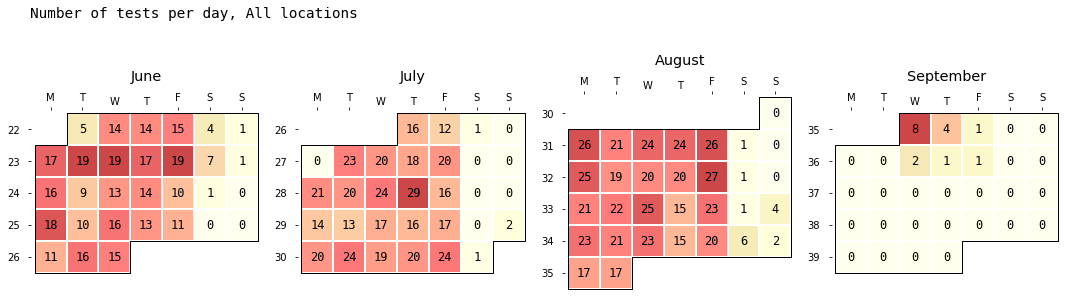

In [6]:
df_plot = test_data.groupby(['START_TIMESTAMP_Date']).TEST_ID.count()
df_plot.index = df_plot.index.astype(str)
visuals_prepared.plot_calendar(df_plot, title='Number of tests per day, All locations', num_month=4)

[To list of questions](#Data-Analysis)

### Testing: Trends by day

**Note:** We do see the daily and weekly aggregated dynamics of number of tests. The acceleration (MA(2) of percentage changes WOW) of test number change decreased at the mid of period, but after that we encamped the plateau which we could hike only 1/4 of time before. Maybe, we achieved the local or global optimum.

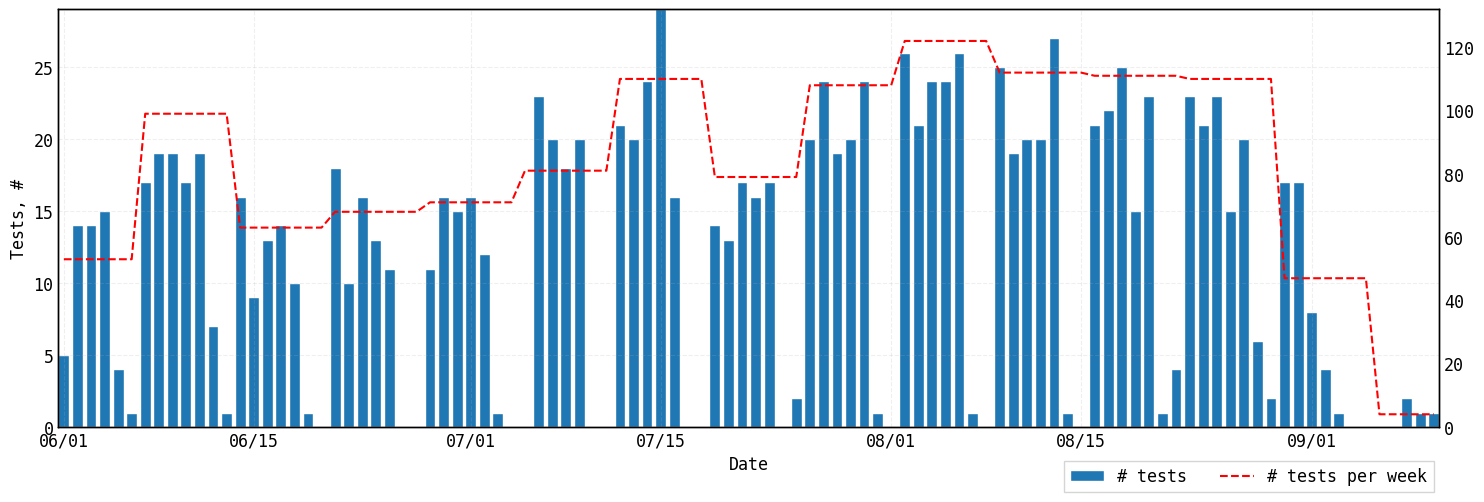

In [7]:
df_aux = test_data.groupby(['START_TIMESTAMP_Date']).TEST_ID.count()
df_aux = df_aux.resample('D').asfreq().fillna(0)
df_aux_week = df_aux.resample('W').sum()

df_plot = pd.merge(left=df_aux, 
             right=df_aux.resample('W').sum(),
             left_on=df_aux.index.week,
             right_on=df_aux_week.index.week,
             how='left')
df_plot.index = df_aux.index

visuals_prepared.plot_testing_trends(df_plot)
#plt.title('Trends in numbers of tests', x=-0.00, horizontalalignment='left');

[To list of questions](#Data-Analysis)

### Testing: Trends by week and location

**Note:** We see a distribution of test numbers started over time, week by week, by locations. There is a location `CC` that started more tests then other locations, the number of tests there is up to 4 times higher than the sample mean.

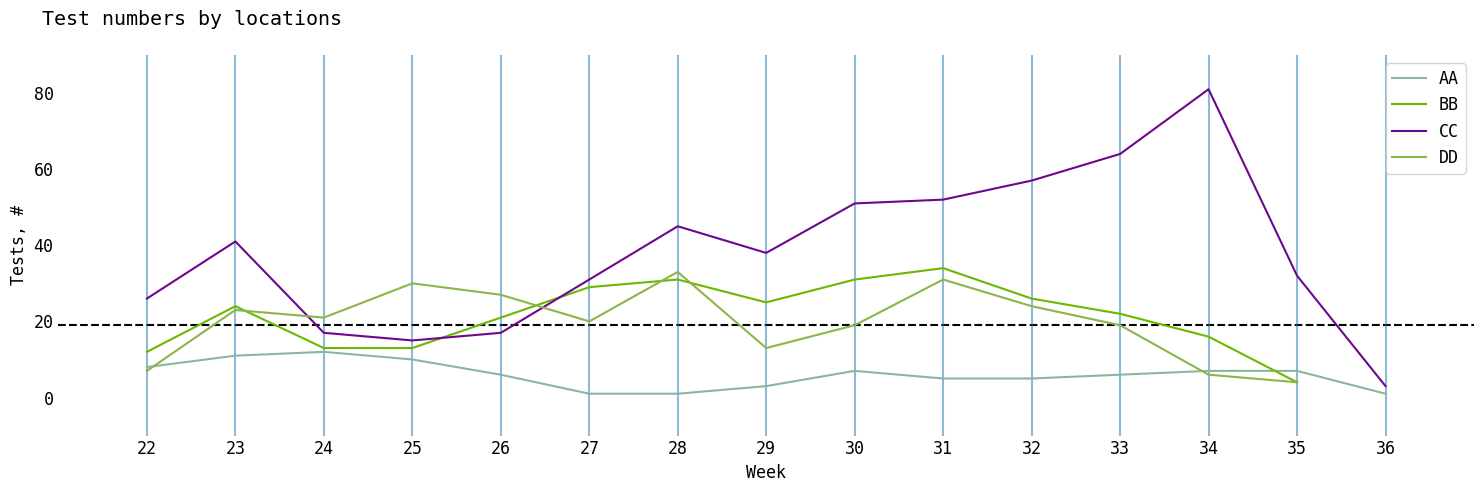

In [8]:
df_aux = test_data.groupby(['START_TIMESTAMP_Week', 'TEST_LOCATION']).TEST_ID.count()
df_aux = df_aux.unstack(0).reset_index()

visuals_prepared.plot_parallel_coordinates(df_aux, 'Test numbers by locations', 'TEST_LOCATION', 
                          xlabel='Week', ylabel='Tests, #', xlim=(-1, 15), ylim=(-10, 90))

In [9]:
df_aux

START_TIMESTAMP_Week,TEST_LOCATION,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
0,AA,8.0,11.0,12.0,10.0,6.0,1.0,1.0,3.0,7.0,5.0,5.0,6.0,7.0,7.0,1.0
1,BB,12.0,24.0,13.0,13.0,21.0,29.0,31.0,25.0,31.0,34.0,26.0,22.0,16.0,4.0,NaN
2,CC,26.0,41.0,17.0,15.0,17.0,31.0,45.0,38.0,51.0,52.0,57.0,64.0,81.0,32.0,3.0
3,DD,7.0,23.0,21.0,30.0,27.0,20.0,33.0,13.0,19.0,31.0,24.0,19.0,6.0,4.0,NaN


[To table of contents](#TOC) | [To list of questions](#Data-Analysis)
***

> ## Testing: In-Depth Look
Let's dig into testing deep

### Testing: When we test?

**How this chart build?** We've run through every test and increment the timeline of abstract day by intervals with time when these tests were active

**Note:** We see an aggregated activity, a proxy-workload and utilisation of all our assets - when our tests were active. When Vehicles, Locations, Operating staff are all busy. We see, there are downward trends from 21 PM to next Midday. However, it's a well known fact the time closer to sunrise is the most dangerous for human drivers. Otherwise, there are two peaks of testing activity - midday (about 2PM) and evening (about 8PM)

CPU times: user 70.3 ms, sys: 3.51 ms, total: 73.8 ms
Wall time: 72 ms


[None, None, None, None]

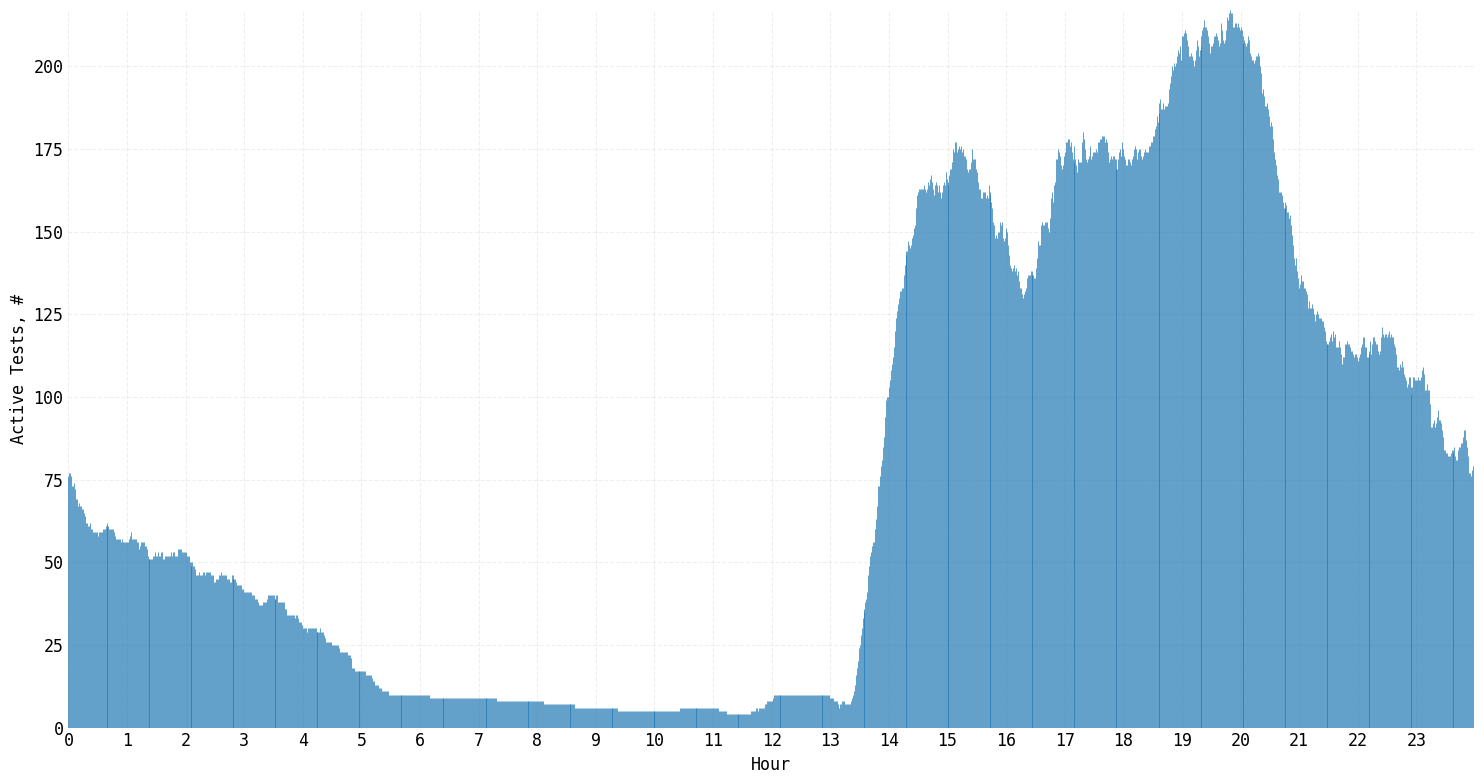

In [10]:
%%time
precision = 'm'
df_aux = test_data[['START_TIMESTAMP_Time', 'TEST_LENGTH']]
df_aux, interval_range = analytical_processing._prepare_testing_timelines(df_aux, precision=precision)

ax = visuals_prepared.plot_timely_activity(df_aux, precision=precision, interval_range=interval_range)
[item.set_visible(False) for item in plt.gca().spines.values()];

[To list of questions](#Data-Analysis)

### Testing: Features. Distance & Test length

**Note:** All distributions are either zero-inflated or left skewed. We need additional expertise here to understand operations and answer why so many tiny values, but usually people split such a mixtures to at least two parts (zeros and other), visually here we might have three. From points of improvements, we need to know test scenarios, test goals, ODD

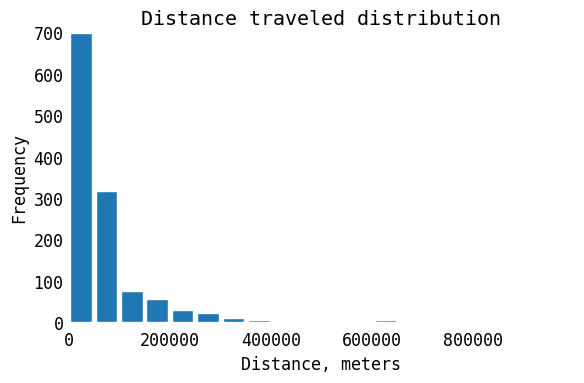

In [11]:
df_aux = test_data.DISTANCE_TRAVELED_M.sort_values()

ax = visuals_prepared.plot_hists(df_aux, bins=20, ylims=(-10, 710), xlims=(-5, None), 
                xlabel='Distance, meters', title='Distance traveled distribution');
[item.set_visible(False) for item in plt.gca().spines.values()];

[None, None, None, None]

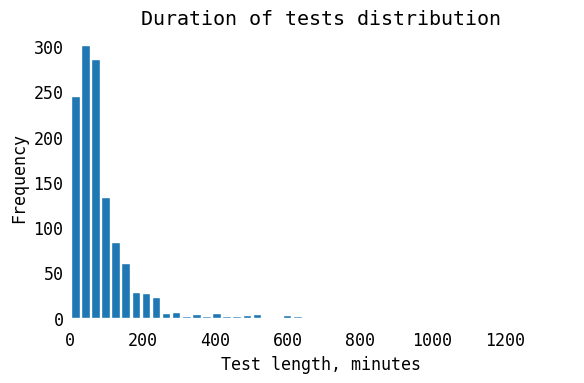

In [12]:
df_aux = test_data.TEST_LENGTH.sort_values()
df_aux = df_aux.astype('timedelta64[m]')

ax = visuals_prepared.plot_hists(df_aux, bins=50, ylims=(-10, 320), xlims=(-5, None), 
                xlabel='Test length, minutes', title='Duration of tests distribution')
[item.set_visible(False) for item in plt.gca().spines.values()]

In [13]:
test_data[test_data['TEST_LENGTH'] < '10 min']

,TEST_ID,TEST_LOCATION,VEHICLE_ID,START_TIMESTAMP,END_TIMESTAMP,DISTANCE_TRAVELED_M,INTERVENTIONS,TEST_LENGTH,START_TIMESTAMP_Date,START_TIMESTAMP_Year,...,START_TIMESTAMP_Time,END_TIMESTAMP_Date,END_TIMESTAMP_Year,END_TIMESTAMP_Month,END_TIMESTAMP_Week,END_TIMESTAMP_DOW,END_TIMESTAMP_Hour,END_TIMESTAMP_Time,Vehicle_Speed_M_per_second,DISTANCE_TRAVELED_Mile
26,1271354,CC,V18,2021-08-10 20:32:08,2021-08-10 20:33:59,0.000638,0,0 days 00:01:51,2021-08-10,2021,...,20:32:08,2021-08-10,2021,8,32,1,20,20:33:59,5.748854e-06,3.965111e-07
46,1154969,DD,V20,2021-06-23 22:49:07,2021-06-23 22:54:09,127.748841,2,0 days 00:05:02,2021-06-23,2021,...,22:49:07,2021-06-23,2021,6,25,2,22,22:54:09,4.230094e-01,7.937945e-02
52,1154645,DD,V01,2021-06-23 16:34:43,2021-06-23 16:37:08,0.001188,0,0 days 00:02:25,2021-06-23,2021,...,16:34:43,2021-06-23,2021,6,25,2,16,16:37:08,8.191432e-06,7.380384e-07
60,1250074,CC,V19,2021-08-05 13:16:44,2021-08-05 13:17:10,0.000220,3,0 days 00:00:26,2021-08-05,2021,...,13:16:44,2021-08-05,2021,8,31,3,13,13:17:10,8.453301e-06,1.365686e-07
76,1275484,BB,V09,2021-08-18 20:45:31,2021-08-18 20:54:43,1345.265499,0,0 days 00:09:12,2021-08-18,2021,...,20:45:31,2021-08-18,2021,8,33,2,20,20:54:43,2.437075e+00,8.359092e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,1140623,CC,V05,2021-06-25 16:38:11,2021-06-25 16:38:54,0.000180,0,0 days 00:00:43,2021-06-25,2021,...,16:38:11,2021-06-25,2021,6,25,4,16,16:38:54,4.195301e-06,1.120941e-07
1201,1314944,CC,V21,2021-08-30 19:33:12,2021-08-30 19:38:42,0.000140,2,0 days 00:05:30,2021-08-30,2021,...,19:33:12,2021-08-30,2021,8,35,0,19,19:38:42,4.253331e-07,8.721562e-08
1204,1094485,CC,V07,2021-06-03 18:36:15,2021-06-03 18:38:34,0.000148,2,0 days 00:02:19,2021-06-03,2021,...,18:36:15,2021-06-03,2021,6,22,3,18,18:38:34,1.063853e-06,9.188563e-08
1227,1253736,AA,V06,2021-08-03 23:44:06,2021-08-03 23:51:51,834.039745,0,0 days 00:07:45,2021-08-03,2021,...,23:44:06,2021-08-03,2021,8,31,1,23,23:51:51,1.793634e+00,5.182483e-01


[None, None, None, None]

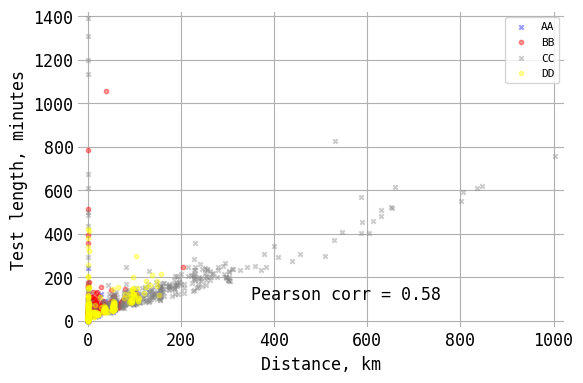

In [14]:
df_aux = test_data[['DISTANCE_TRAVELED_M', 'TEST_LENGTH', 'TEST_LOCATION']]
df_aux['DISTANCE_TRAVELED_M'] = df_aux.DISTANCE_TRAVELED_M / 1000
df_aux['TEST_LENGTH'] = df_aux.TEST_LENGTH.astype('timedelta64[m]')

fig, ax = plt.subplots()

colors = {'AA':'blue', 'BB':'red', 'CC':'grey', 'DD':'yellow'}
markers = ['x', 'o', 'x', 'o']

for indx, (loc, group) in enumerate(df_aux.groupby('TEST_LOCATION')):
    ax.scatter(x=group.DISTANCE_TRAVELED_M, 
               y=group.TEST_LENGTH, 
                marker=markers[indx], 
                color=colors[loc], 
                s=10, alpha=0.4, label=loc, zorder=3)
ax.legend(scatterpoints=1, fontsize=8)

ax.grid(zorder=5)

ax.text(*(350, 100), 'Pearson corr = 0.58', )

ax.set_xlabel('Distance, km')
ax.set_ylabel('Test length, minutes')

ax.margins(x=0.02, y=0.02)
#ax.set_ylim(-30)

plt.tight_layout()
[item.set_visible(False) for item in plt.gca().spines.values()]

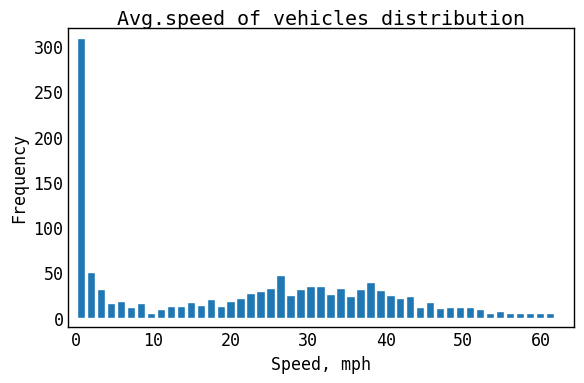

In [15]:
df_aux = test_data.DISTANCE_TRAVELED_M / test_data.TEST_LENGTH.astype('timedelta64[s]')
df_aux *= 2.237 # meters per second to miles per hour conversion
#df_aux = np.log1p(df_aux)

ax = visuals_prepared.plot_hists(df_aux, bins=50, ylims=(-10, 320), xlims=(-1, None), 
                xlabel='Speed, mph', title='Avg.speed of vehicles distribution')

[To list of questions](#Data-Analysis)

### Testing: Overall distance distribution

**Note** We see the distribution of distances over tests

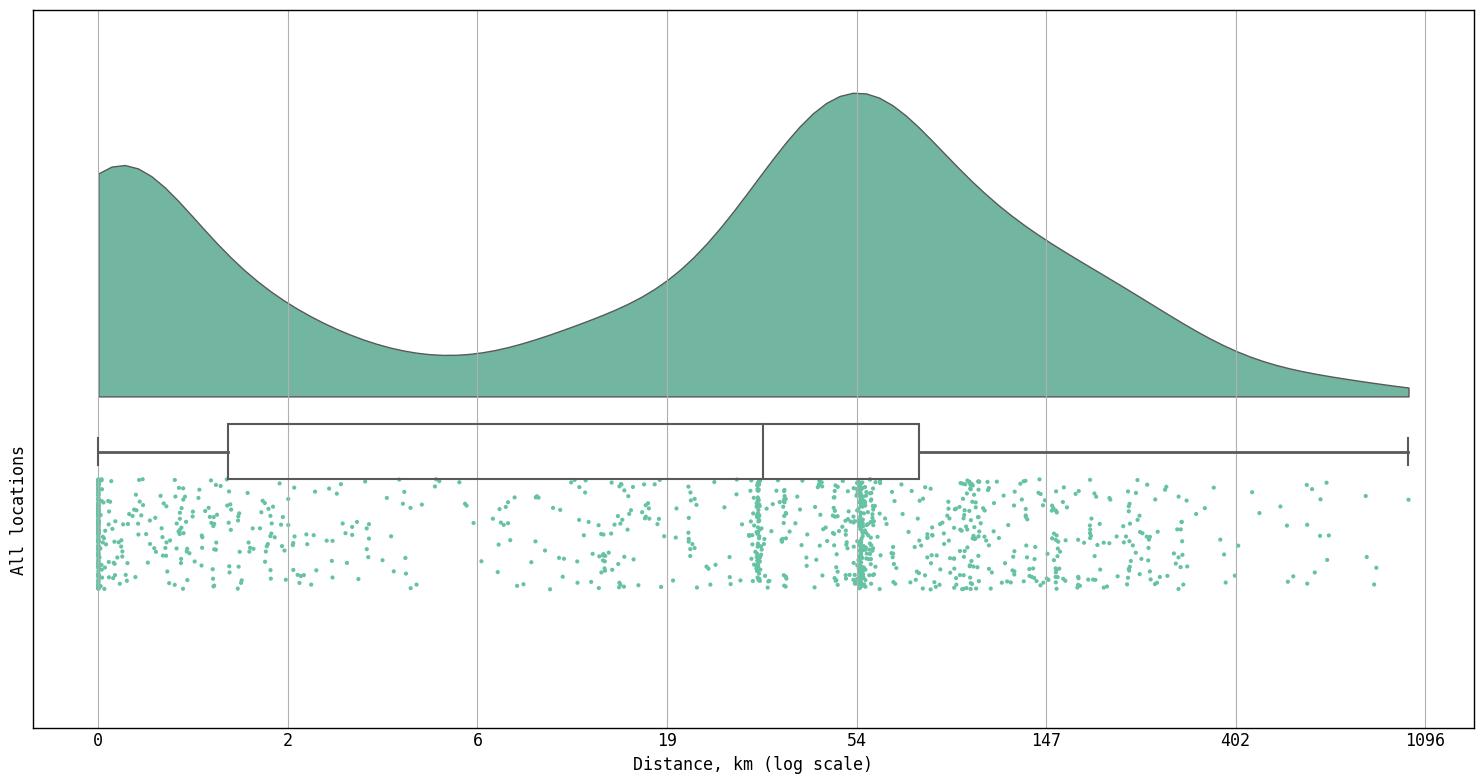

In [16]:
df_aux = test_data[['DISTANCE_TRAVELED_M']]
df_aux['DISTANCE_TRAVELED_M'] = np.log1p(df_aux['DISTANCE_TRAVELED_M'] / 1000)
#df_aux['LENGTH_FLAG'] = np.where(df_aux['DISTANCE_TRAVELED_M'] > 500, 1, 0)

f, ax = plt.subplots(figsize=(15, 8))

ax = pt.RainCloud(data=df_aux, #hue='LENGTH_FLAG',
                  palette='Set2', edgecolor='white', 
                  width_box=0.1, width_viol=1.1, move=0.15, 
                  dodge=True, offset=0.1,
                  orient='h', pointplot=False
                 )

ax.grid(axis='x')
#ax.ticklabel_format(style='plain', axis='x')
ax.margins(x=0.05) # #ax.set_xlim(0, 8)
ticks_labels = [round(np.exp(float(tick_label)) - 1) for tick_label in plt.xticks()[0]]
ax.set_xticklabels(ticks_labels)

ax.set_xlabel('Distance, km (log scale)')
ax.set_ylabel(''); ax.set_yticklabels(['All locations'], rotation=90)

f.tight_layout()

[To list of questions](#Data-Analysis)

### Testing: Features. Test distance per locations
**Note** We see the distribution of distances over tests by locations

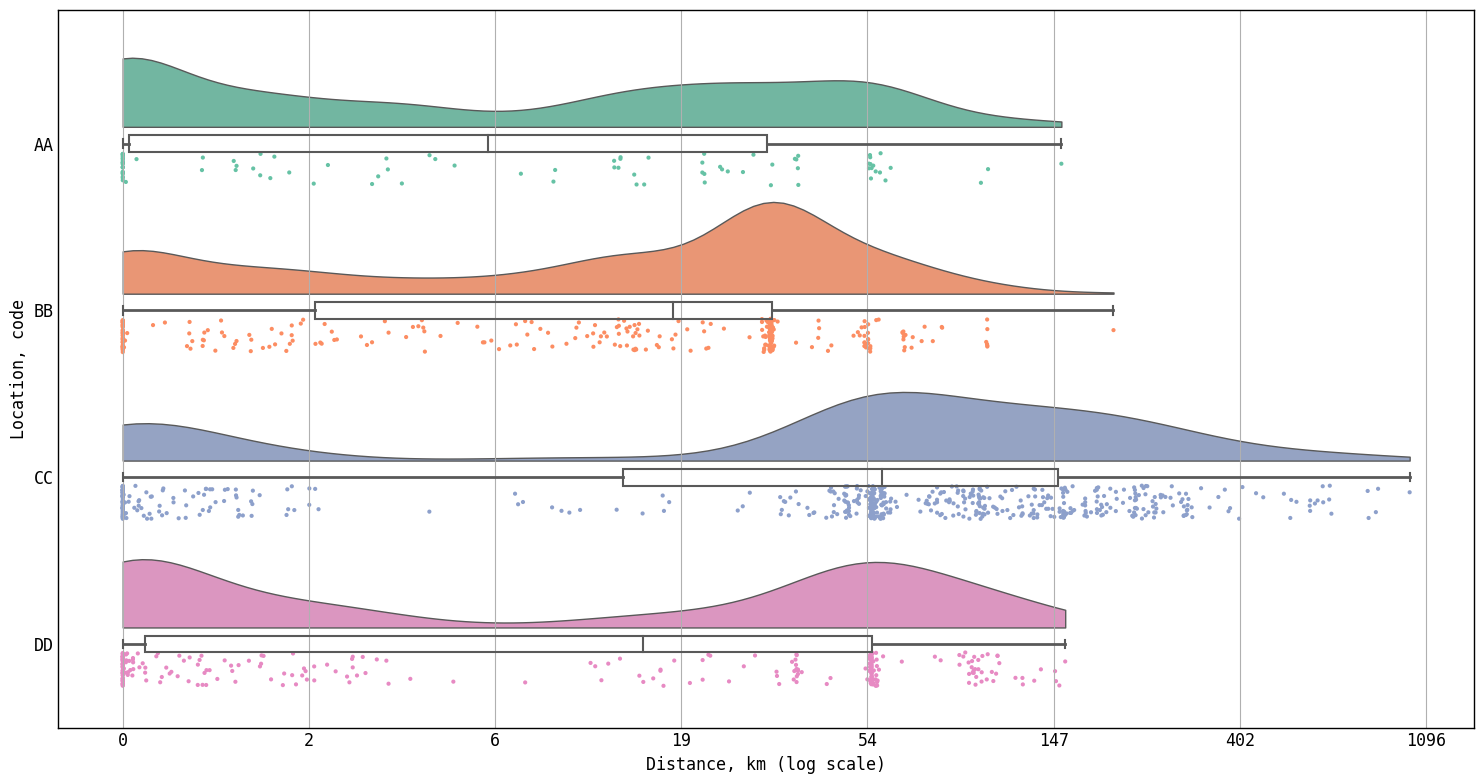

In [17]:
df_aux = test_data[['TEST_LOCATION', 'DISTANCE_TRAVELED_M']]
df_aux['DISTANCE_TRAVELED_M'] = np.log1p(df_aux['DISTANCE_TRAVELED_M'] / 1000)
df_aux['LENGTH_FLAG'] = np.where(df_aux['DISTANCE_TRAVELED_M'] > 500, 1, 0)

f, ax = plt.subplots(figsize=(15, 8))

ax = pt.RainCloud(x='TEST_LOCATION', y="DISTANCE_TRAVELED_M", 
                  data=df_aux, #hue='LENGTH_FLAG',
                  palette='Set2', edgecolor='white', 
                  width_box=0.1, width_viol=1.1, move=0.15, 
                  dodge=True, offset=0.1,
                  orient='h', pointplot=False,
                  order=['AA', 'BB', 'CC', 'DD']
                 )

ax.grid(axis='x')
#ax.ticklabel_format(style='plain', axis='x')
ax.margins(x=0.05) # #ax.set_xlim(0, 8)
ticks_labels = [round(np.exp(float(tick_label)) - 1) for tick_label in plt.xticks()[0]]
ax.set_xticklabels(ticks_labels)

ax.set_xlabel('Distance, km (log scale)')
ax.set_ylabel('Location, code')

f.tight_layout()

[To list of questions](#Data-Analysis)

### Testing: Didstance by location and vehicle
**Note** We see the distribution of distances over tests by vehicle

**Note:** We may add interactive location pick extension here but me to lazy now

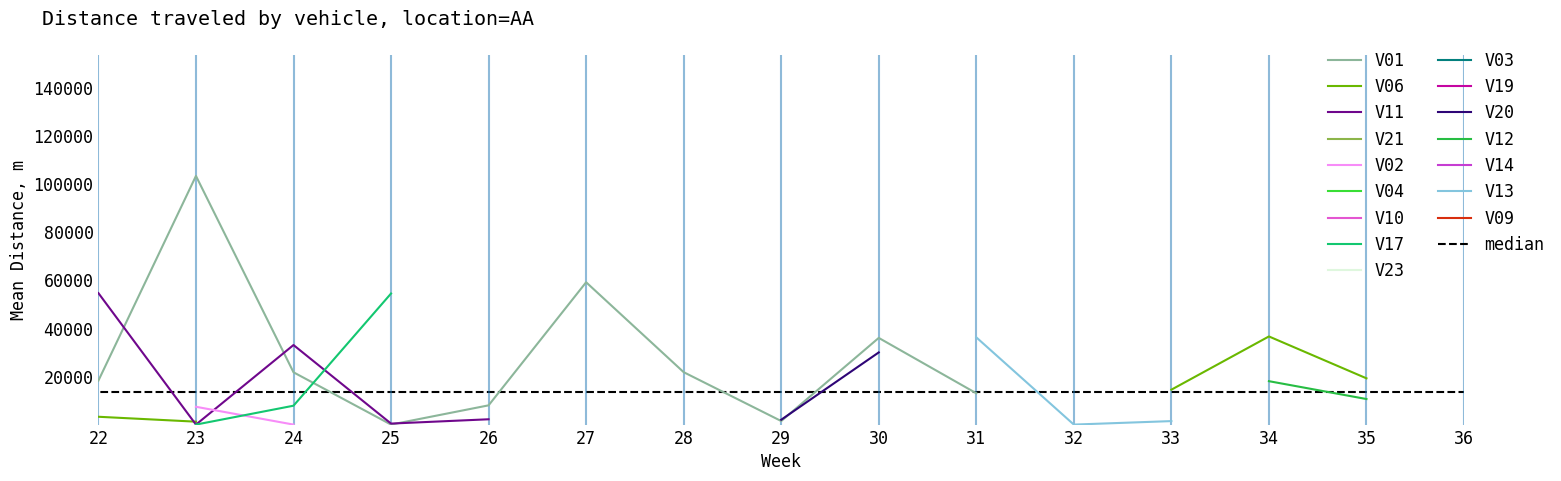

In [18]:
df_aux = test_data.groupby(['TEST_LOCATION', 'START_TIMESTAMP_Week', 'VEHICLE_ID']).DISTANCE_TRAVELED_M.mean()
df_aux = df_aux.xs(key='AA', level='TEST_LOCATION').unstack(0).reset_index() # pick location

visuals_prepared.plot_parallel_coordinates(df_aux, 'Distance traveled by vehicle, location=AA', 'VEHICLE_ID', 
                          xlabel='Week', ylabel='Mean Distance, m', xlim=(None, None), ylim=(None, None))
plt.legend(loc='right', ncol=2, bbox_to_anchor=(1.07, 0.7), frameon=False);

### Testing: Features. Interventions and distance traveled per location

**Note** We see the distribution of distances by locations and number of interventions

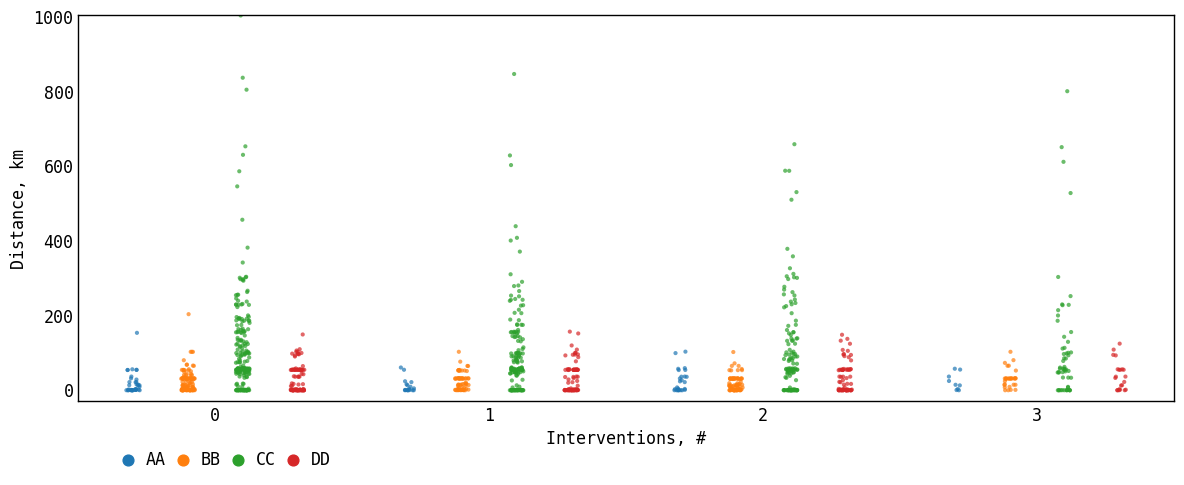

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))

df_aux = test_data[['DISTANCE_TRAVELED_M', 'TEST_LOCATION', 'INTERVENTIONS']]
df_aux['DISTANCE_TRAVELED_M'] = df_aux['DISTANCE_TRAVELED_M'] / 1000

ax = sns.stripplot(data=df_aux, x="INTERVENTIONS", y="DISTANCE_TRAVELED_M", hue="TEST_LOCATION",
                   dodge=True, alpha=.7, size=3, zorder=1)
                   # palette={'AA':'blue', 'BB':'orange', 'CC':'green', 'DD':'red'}

ax.set_xlabel('Interventions, #')
ax.set_ylabel('Distance, km')

ax.set_ylim(-30)

ax.legend(loc='center', bbox_to_anchor=(0.13, -.15), ncol=4, fancybox=False, shadow=False,
         title='', frameon=False, handletextpad=0.1, columnspacing=0)
fig.tight_layout()

**Note:** We see the distribution of distance by interventions per locations.

[To table of contents](#TOC) | [To list of questions](#Data-Analysis)
***

> ## Testing: Executive Metrics Report

**Note** Executive report is better suited to `.PPTX`. Here are just row numbers

### Metrics 

In [20]:
df_aux = test_data[['TEST_LOCATION', 'DISTANCE_TRAVELED_M', 'TEST_LENGTH', 'INTERVENTIONS', 'START_TIMESTAMP_Week']]
df_aux['TEST_LENGTH'] = df_aux.TEST_LENGTH.astype('timedelta64[m]')

df_aux_general = df_aux.pivot_table(index = 'TEST_LOCATION',
                        values = ['DISTANCE_TRAVELED_M', 'TEST_LENGTH', 'INTERVENTIONS'],
                        aggfunc = [np.sum, np.mean, np.median, np.std], 
                        margins = True, margins_name='All'
                        )

df_aux_general.unstack(0).unstack(1).unstack(1).T

sum           mean        median  \
                    TEST_LOCATION                                              
DISTANCE_TRAVELED_M AA             1.761563e+06   19572.926680   6214.554110   
                    BB             7.099413e+06   23586.088774  18252.192088   
                    CC             6.206172e+07  108880.208949  58024.262829   
                    DD             9.019456e+06   32561.213249  15376.118560   
                    All            7.994215e+07   64573.627862  32303.012806   
INTERVENTIONS       AA             9.700000e+01       1.077778      1.000000   
                    BB             3.210000e+02       1.066445      1.000000   
                    CC             5.980000e+02       1.049123      1.000000   
                    DD             2.950000e+02       1.064982      1.000000   
                    All            1.311000e+03       1.058966      1.000000   
TEST_LENGTH         AA             3.548000e+03      39.422222     31.500000   
                    BB             1.982500e+04      65.863787     51.000000   
                    CC             6.975500e+04     122.377193     83.500000   
                    DD             1.805800e+04      65.191336     54.000000   
                    All            1.111860e+05      89.810985     62.500000   

                                             std  
                    TEST_LOCATION                 
DISTANCE_TRAVELED_M AA              27407.217444  
                    BB              24978.601680  
                    CC             137935.256673  
                    DD              38331.348481  
                    All            104719.706228  
INTERVENTIONS       AA                  1.051780  
                    BB                  1.046695  
                    CC                  1.003180  
                    DD                  0.964647  
                    All                 1.007522  
TEST_LENGTH         AA                 35.884013  
                    BB                 86.679398  
                    CC                146.490389  
                    DD                 63.598402  
                    All               116.730188

### Mean WOW change for metrics

In [21]:
agg_map_dict = {'DISTANCE_TRAVELED_M' : np.sum, 'INTERVENTIONS' : np.sum, 'TEST_LENGTH' : np.sum}

df_aux_WOW = df_aux.groupby(['START_TIMESTAMP_Week', 'TEST_LOCATION'])\
    .agg(agg_map_dict)\
    .groupby('TEST_LOCATION').pct_change(1)\
    .replace([np.inf, -np.inf], np.nan)\
    .groupby('TEST_LOCATION').agg([np.mean, np.median])
# .xs(level='TEST_LOCATION', key='AA')
df_aux_WOW = df_aux_WOW.unstack(0).unstack(0).unstack(1).T
df_aux_WOW
#there were weeks with zero interventions

mean    median
                    TEST_LOCATION                    
DISTANCE_TRAVELED_M AA             2.930169 -0.302740
                    BB             0.062136 -0.201768
                    CC             0.078712 -0.016289
                    DD             0.607227 -0.289538
INTERVENTIONS       AA             0.292308 -0.200000
                    BB             0.110557 -0.055556
                    CC             0.116456  0.076772
                    DD             0.111771 -0.111111
TEST_LENGTH         AA             0.301946 -0.092220
                    BB             0.121581 -0.015556
                    CC             0.014925 -0.059624
                    DD             0.347033  0.051864

[To table of contents](#TOC) | [To list of questions](#Data-Analysis)
***

> ## Troubleshooting view

### Troubleshooting: Calendar of troubleshootings

**Note** We see the number of troubleshooting per (testing) day

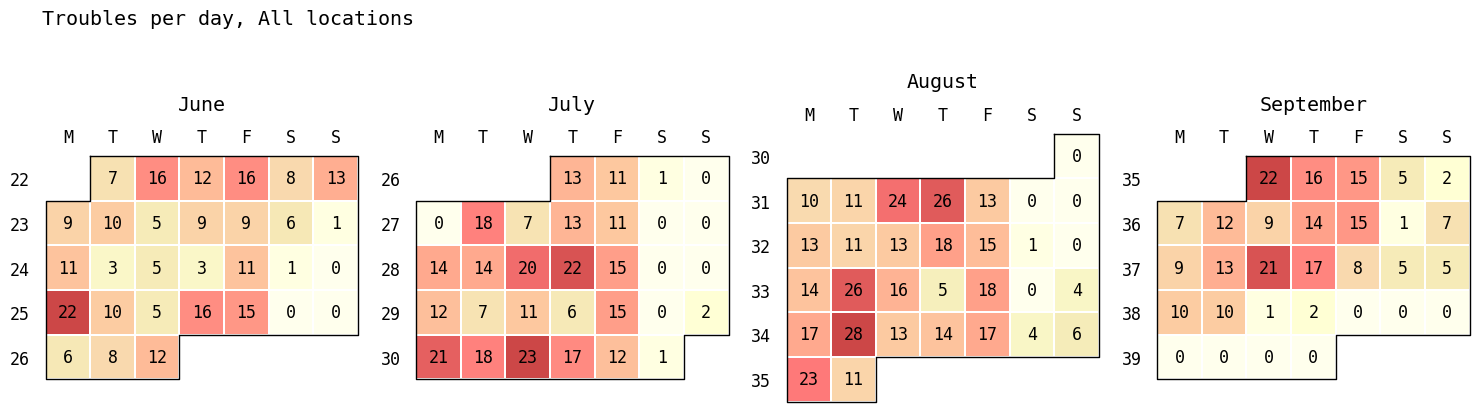

In [22]:
df_plot = troubleshoot_data.groupby('TROUBLESHOOTING_START_Date').TROUBLESHOOTING_ID.count()
df_plot.index = df_plot.index.astype(str)

visuals_prepared.plot_calendar(df_plot,
                              'Troubles per day, All locations', 4)

[To list of questions](#Data-Analysis)

### Troubleshooting: Troubleshootings length by Root Cause

**Note** We see the number of troubleshooting per (testing) Root Cause

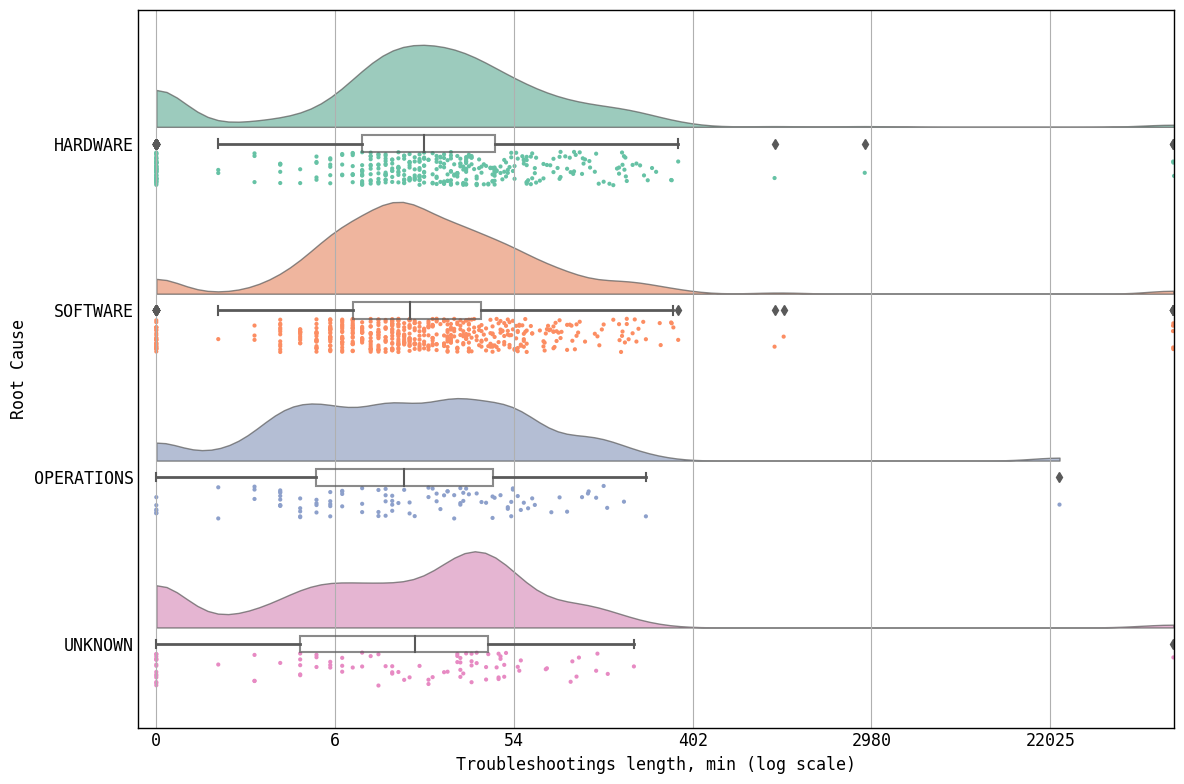

In [23]:
df_aux = troubleshoot_data[['TROUBLESHOOTING_LENGTH', 'ROOT CAUSE']]
df_aux['TROUBLESHOOTING_LENGTH'] = df_aux['TROUBLESHOOTING_LENGTH'].astype('timedelta64[m]')
df_aux['LENGTH_FLAG'] = np.where(df_aux['TROUBLESHOOTING_LENGTH'] > 600, 1, 0)

df_aux['TROUBLESHOOTING_LENGTH'] = np.log1p(df_aux['TROUBLESHOOTING_LENGTH'])

f, ax = plt.subplots(1, 1, figsize=(12, 8))

ax = pt.RainCloud(y='TROUBLESHOOTING_LENGTH', x='ROOT CAUSE', #hue='LENGTH_FLAG',
                  data=df_aux,
                  width_box=0.1, width_viol=1.1, move=0.15, 
                  dodge=True, offset=0.1,
                  orient='h', alpha=0.7)

ax.grid(axis='x')
ax.set_xlim(-0.2, None) # ax.margins(x=0.01)
ticks_labels = [round(np.exp(float(tick_label)) - 1) for tick_label in plt.xticks()[0]]
ax.set_xticklabels(ticks_labels)

ax.set_xlabel('Troubleshootings length, min (log scale)')
ax.set_ylabel('Root Cause')

f.tight_layout()

[To list of questions](#Data-Analysis)

### Troubleshooting: Features. Troubleshooting length & Frequency

**Note:** Majority, 0.75 of troubles took less then an 3/4 hour. 0.95 of them took less then 3 hours. It worth to additionly see them in dynamics over time, by assets and location-wise.

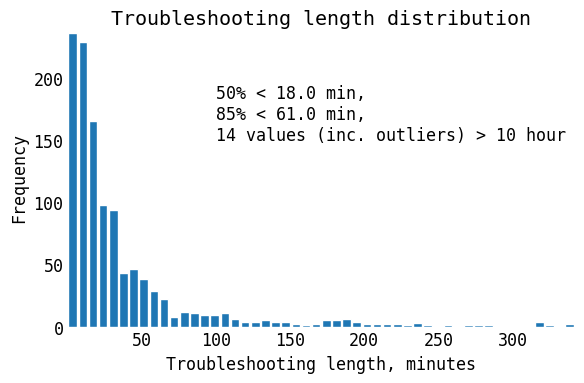

In [24]:
df_aux = troubleshoot_data.TROUBLESHOOTING_LENGTH.sort_values()
df_aux = df_aux.astype('timedelta64[m]')

note = f'50% < {df_aux.median()} min,\n85% < {df_aux.quantile(0.85)} min,\n{(df_aux > 600).sum()} values (inc. outliers) > 10 hour'

df_aux = df_aux[df_aux < 600]

ax = visuals_prepared.plot_hists(df_aux, bins=50, xlims=(None, None), ylims=(None, 240),  
                                 xlabel='Troubleshooting length, minutes', 
                                 title='Troubleshooting length distribution')

ax.text(x=100, y=150, s=note);

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

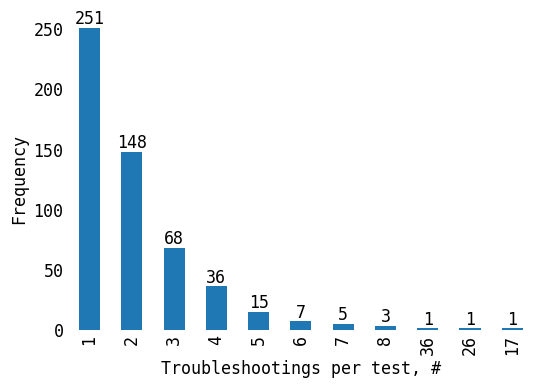

In [25]:
df_aux = troubleshoot_data.groupby('TEST_ID').TROUBLESHOOTING_ID.count().value_counts().plot.bar()

ax = troubleshoot_data.groupby('TEST_ID').TROUBLESHOOTING_ID.count().value_counts().plot.bar()

ax.bar_label(ax.containers[0], label_type='edge')
#plt.yticks([])
ax.set_xlabel('Troubleshootings per test, #')
ax.set_ylabel('Frequency')
#ax.grid(axis='y', zorder=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

[To table of contents](#TOC) | [To list of questions](#Data-Analysis)
***

> ## Troubleshooting: Executive Metrics Report

**Note** Executive report is better suited to `.PPTX`. Here are just row numbers

In [26]:
df_aux = troubleshoot_data.drop_duplicates('TEST_ID')[['TROUBLESHOOTING_LENGTH', 'TROUBLES_PER_TEST', 'TROUBLESHOOTING_START_Week']]
df_aux['TROUBLESHOOTING_LENGTH'] = df_aux.TROUBLESHOOTING_LENGTH.astype('timedelta64[m]')

df_aux_general = df_aux.pivot_table(index = 'TROUBLESHOOTING_START_Week',
                        values = ['TROUBLES_PER_TEST'],
                        aggfunc = [np.sum, np.mean, np.median, np.std], 
                        margins = True, margins_name='All'
                        )

df_aux_general.unstack(0).unstack(1).unstack(1).T

sum      mean  median  \
                  TROUBLESHOOTING_START_Week                             
TROUBLES_PER_TEST 22                            77.0  2.851852     2.0   
                  23                            50.0  2.000000     2.0   
                  24                            36.0  2.117647     2.0   
                  25                            61.0  4.692308     2.0   
                  26                            65.0  3.823529     1.0   
                  27                            35.0  1.750000     1.5   
                  28                            84.0  2.153846     2.0   
                  29                            62.0  2.952381     2.0   
                  30                            83.0  2.075000     2.0   
                  31                            84.0  2.000000     2.0   
                  32                            74.0  1.897436     2.0   
                  33                            83.0  1.765957     1.0   
                  34                            99.0  1.767857     1.0   
                  35                            93.0  2.066667     1.0   
                  36                            64.0  2.000000     2.0   
                  37                            77.0  1.833333     1.0   
                  38                            23.0  1.642857     1.0   
                  All                         1150.0  2.145522     2.0   

                                                   std  
                  TROUBLESHOOTING_START_Week            
TROUBLES_PER_TEST 22                          1.974914  
                  23                          1.190238  
                  24                          1.763603  
                  25                          9.463831  
                  26                          6.894158  
                  27                          0.910465  
                  28                          1.367642  
                  29                          1.909874  
                  30                          1.384669  
                  31                          1.104315  
                  32                          1.020703  
                  33                          0.960361  
                  34                          1.401182  
                  35                          1.321157  
                  36                          1.135924  
                  37                          1.267159  
                  38                          1.277446  
                  All                         2.321480

[To table of contents](#TOC) | [To list of questions](#Data-Analysis)
***

> ## Experiment Part. Testing and Troubleshooting: Connection

The basic assumption is that dataframes connected in this-like way. 
```
Test 1270798, Location CC
Test from 2021-08-11 01:27:36 to 2021-08-11 04:19:57
                
    Trouble one from 2021-08-10 23:50:34 to 2021-08-11 00:42:34
    Trouble two from 2021-07-12 19:31:12 to 2021-07-12 20:47:12
```

However, data may and does contain grey parts
* There were unique test's id codes (TEST_ID exist in only one of two datasets)
* There were troubleshootings with more then one ROOT CAUSE for the same time, like both SOFTWARE and HARDWARE
* There were troubleshootings' TROUBLESHOOTING_START after the test's END_TIMESTAMP and troubleshootings' TROUBLESHOOTING_START before test's START_TIMESTAMP

_The expert's comments we had are below:_
> * Troubleshooting instances occur during tests, and there is a 1:many relationship between Test and Troubleshooting Instance. There may be errors in this data set.
> * Manual Interventions occur during vehicle operation in autonomy and are when a human driver is required to take over the vehicle from the autonomy systems. Troubleshooting Instances occur during testing, and are indications that there is an error with software, hardware, or an operational procedure that requires diagnosis before testing may resume. There may or may not be a correlation between these.

In [27]:
aux = pd.merge(test_data, troubleshoot_data, left_on='TEST_ID', right_on='TEST_ID', how='outer')
# aux = (aux.TEST_LENGTH - aux.TROUBLESHOOTING_LENGTH).astype('timedelta64[m]')
# aux[(~aux.TROUBLESHOOTING_ID.isna()) & (~aux.TEST_LOCATION.isna())]

In [28]:
# example TEST_IDs are 1270798 - troubleshooting before testing or 1103102 - troubleshooting after testing
display(test_data[test_data.TEST_ID == 1103102])
display(troubleshoot_data[troubleshoot_data.TEST_ID == 1103102])

,TEST_ID,TEST_LOCATION,VEHICLE_ID,START_TIMESTAMP,END_TIMESTAMP,DISTANCE_TRAVELED_M,INTERVENTIONS,TEST_LENGTH,START_TIMESTAMP_Date,START_TIMESTAMP_Year,...,START_TIMESTAMP_Time,END_TIMESTAMP_Date,END_TIMESTAMP_Year,END_TIMESTAMP_Month,END_TIMESTAMP_Week,END_TIMESTAMP_DOW,END_TIMESTAMP_Hour,END_TIMESTAMP_Time,Vehicle_Speed_M_per_second,DISTANCE_TRAVELED_Mile
44,1103102,CC,V03,2021-06-07 13:49:50,2021-06-07 15:46:15,124579.921569,2,0 days 01:56:25,2021-06-07,2021,...,13:49:50,2021-06-07,2021,6,23,0,15,15:46:15,17.83535,77.410374


,TEST_ID,TROUBLESHOOTING_ID,TROUBLESHOOTING_START,TROUBLESHOOTING_END,ROOT CAUSE,TROUBLESHOOTING_LENGTH,TROUBLESHOOTING_START_Date,TROUBLESHOOTING_START_Year,TROUBLESHOOTING_START_Month,TROUBLESHOOTING_START_Week,TROUBLESHOOTING_START_DOW,TROUBLESHOOTING_START_Hour,TROUBLESHOOTING_START_Time,TROUBLES_PER_TEST
62,1103102,1103015,2021-06-06 14:20:17,2021-06-06 14:44:17,HARDWARE,0 days 00:24:00,2021-06-06,2021,6,22,6,14,14:20:17,5
65,1103102,1103023,2021-06-06 16:19:21,2021-06-06 16:35:21,HARDWARE,0 days 00:16:00,2021-06-06,2021,6,22,6,16,16:19:21,5
66,1103102,1103023,2021-06-06 16:19:21,2021-06-06 16:35:21,SOFTWARE,0 days 00:16:00,2021-06-06,2021,6,22,6,16,16:19:21,5
67,1103102,1103025,2021-06-06 16:41:26,2021-06-06 22:23:26,SOFTWARE,0 days 05:42:00,2021-06-06,2021,6,22,6,16,16:41:26,5
68,1103102,1103025,2021-06-06 16:41:26,2021-06-06 22:23:26,HARDWARE,0 days 05:42:00,2021-06-06,2021,6,22,6,16,16:41:26,5


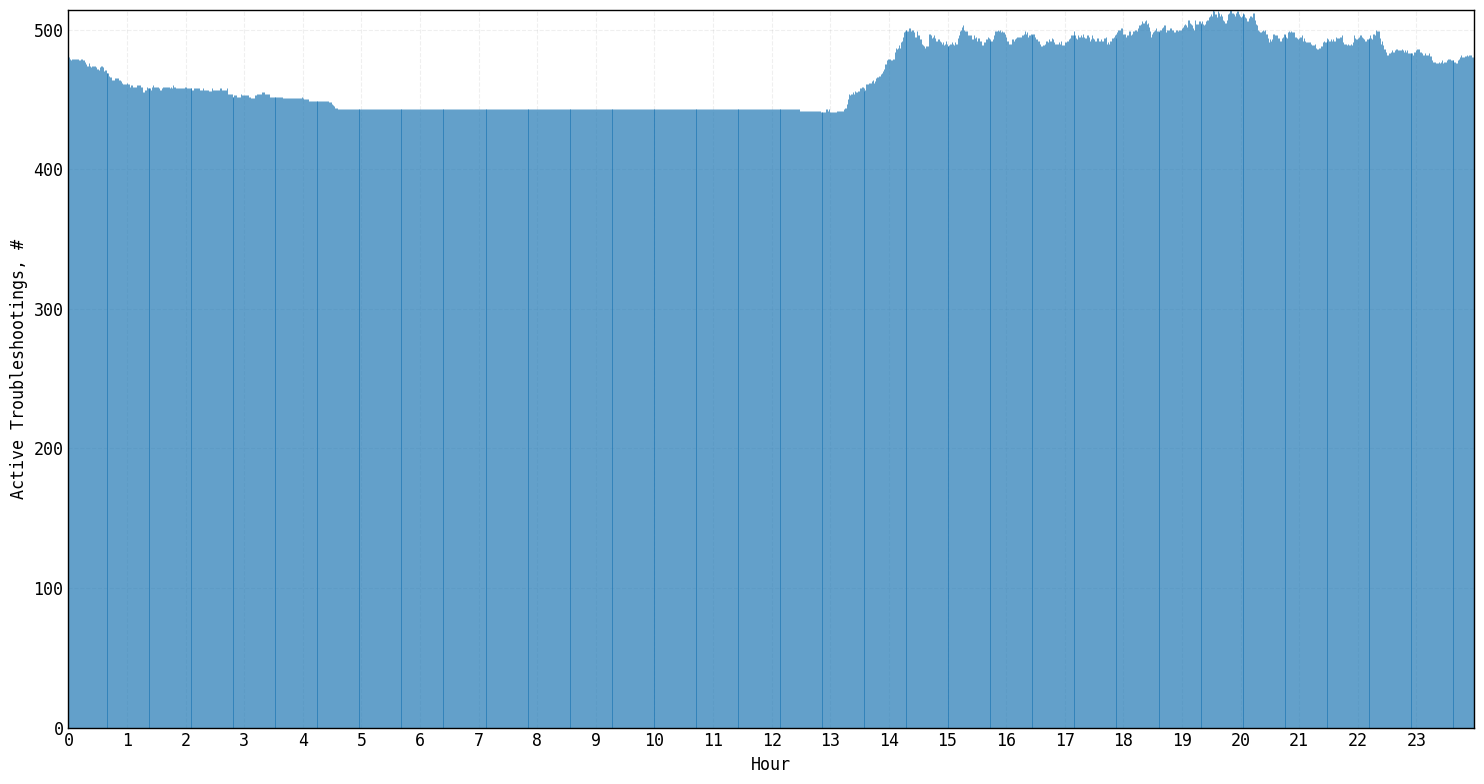

In [29]:
precision = 'm'
df_aux = aux # troubleshoot_data[['TROUBLESHOOTING_START', 'TROUBLESHOOTING_LENGTH']]
df_aux = df_aux[(~df_aux.TROUBLESHOOTING_ID.isna()) & (~df_aux.TEST_LOCATION.isna())][['TROUBLESHOOTING_START', 'TROUBLESHOOTING_LENGTH']]
df_aux, interval_range = analytical_processing._prepare_testing_timelines(df_aux, precision=precision)

visuals_prepared.plot_timely_activity(df_aux, precision=precision, interval_range=interval_range)
plt.ylabel('Active Troubleshootings, #')
#plt.ylim(440, 500)
plt.show()

[To table of contents](#TOC) | [To list of questions](#Data-Analysis)
***